# Notebook for PCA of the data

## Libraries

In [74]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
random.seed(1)
from sklearn.preprocessing import normalize

## Importing the data set
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

In [75]:
# IMPORTANT: Filepath depends on OS!
inpath = r'data/hmnist_28_28_L.csv'
outpath = 'data/hmnist_28_28_L_pcaRed.csv'
df = pd.read_csv(inpath)
print(df) # Shape (#images, h*w+1) (here: (10015, 785))

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            172        182        191        183        180        181   
1             98        149        170        193        183        162   
2            165        164        179        172        152        163   
3            109        159        167        166        163        159   
4            173        202        210        194        208        248   
...          ...        ...        ...        ...        ...        ...   
10010        193        192        191        198        182        191   
10011         93        139        165        183        188        180   
10012        165        191        211        227        222        208   
10013        138        152        154        161        173        177   
10014        152        152        150        148        156        159   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0055  pixel0056  \
0            165   

## Displaying a data image

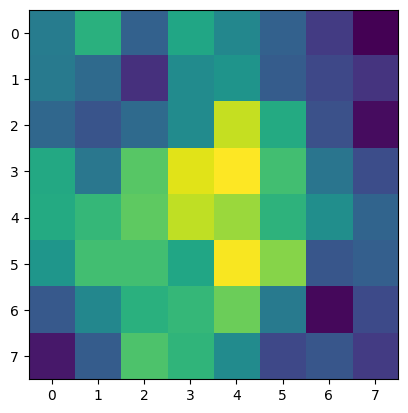

In [76]:
def disp_img(data_vec):
    # Handle the cases of whether the label for an image is provided or not
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    plt.show()


img_number = 9869 # Index of a particular data image
data_vec = df.loc[img_number]

disp_img(data_vec)

# Count occurences of labels
Count the number of data images corresponding to each label.

In [77]:
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)

# Each tuple will contain a label and the number of images with the same label
# [(label, #occurences), ..]
occurences = list(zip(uniq_label, counts_label))
print(occurences)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Importing metadata
This metadata file contains additional information about the patients for each data image (e.g. age, sex, body part where the image has been taken).

In [78]:
# IMPORTANT: Filepath depends on OS!
df_meta = pd.read_csv(r'data/HAM10000_metadata.csv')
print(df_meta)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


# The various diagnostic categories
The labels/numbers represent the following diagnostic categories:

**0)** Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)

**1)** basal cell carcinoma (bcc)

**2)** benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)

**3)** dermatofibroma (df)

**4)** melanoma (mel)

**5)** melanocytic nevi (nv)

**6)** vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

In [79]:
cath = df_meta['dx']
uniq_cath, counts_cath = np.unique(cath, return_counts=True)

diagnoses = list(zip(uniq_cath, counts_cath))
print(diagnoses)

[('akiec', 327), ('bcc', 514), ('bkl', 1099), ('df', 115), ('mel', 1113), ('nv', 6705), ('vasc', 142)]


# Partition the images into the different classes
Create a list of nested lists. Each nested list represents a label and contains the indices of all data images with the same label. E.g. img_index_group[2] contains all images for label 2.

In [80]:
# List of 7 nested lists (for each diagnostical categorie)
# The ith nested list contains the indices of all images, which correspond to label i
# E.g. img_index_group[2] contains all images for label 2
img_index_group = []

for i in range(len(uniq_label)):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)

# Output would exceed the size limit
# print(img_index_group)

# For debugging purposes
# print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))

# Splitting into training and testing data

In [81]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(len(img_index_group)):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

#print(img_index_group_split)

# Running Clustering on the different diagnosis

## Principal Component Analysis

Corresponding to HW4 Question E, find reference for Steps in the posted Solution

### Discarding the labels of the data to create clean matrix for the calculations

In [82]:
data = df.iloc[:, :-1]
print(data)

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            172        182        191        183        180        181   
1             98        149        170        193        183        162   
2            165        164        179        172        152        163   
3            109        159        167        166        163        159   
4            173        202        210        194        208        248   
...          ...        ...        ...        ...        ...        ...   
10010        193        192        191        198        182        191   
10011         93        139        165        183        188        180   
10012        165        191        211        227        222        208   
10013        138        152        154        161        173        177   
10014        152        152        150        148        156        159   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0054  pixel0055  \
0            165   

### Computing Mean of each diagnostics cathegory

Corresponding E.2

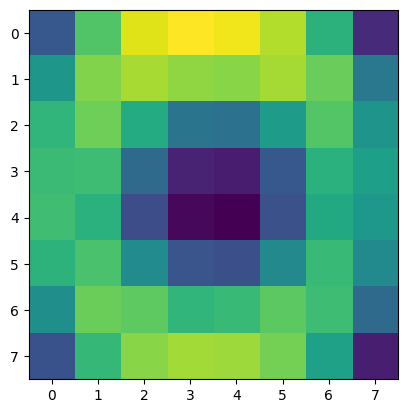

pixel0000    154.850153
pixel0001    169.412844
pixel0002    176.483180
pixel0003    178.103976
pixel0004    177.394495
                ...    
pixel0059    173.605505
pixel0060    173.418960
pixel0061    171.394495
pixel0062    164.333333
pixel0063    148.623853
Length: 64, dtype: float64


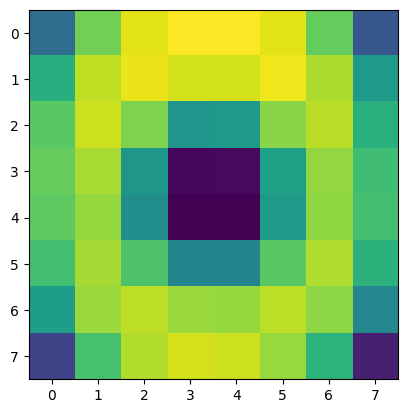

pixel0000    157.836576
pixel0001    171.196498
pixel0002    176.451362
pixel0003    177.747082
pixel0004    177.770428
                ...    
pixel0059    175.747082
pixel0060    175.433852
pixel0061    172.988327
pixel0062    166.813230
pixel0063    149.505837
Length: 64, dtype: float64


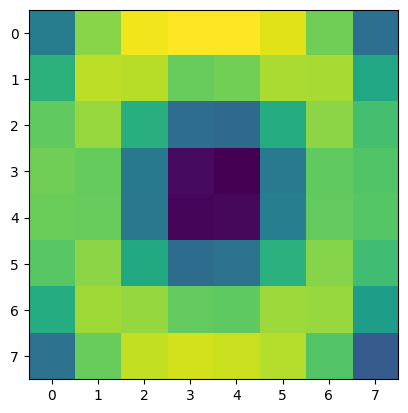

pixel0000    141.517743
pixel0001    158.432211
pixel0002    164.870792
pixel0003    165.828025
pixel0004    165.808007
                ...    
pixel0059    162.892630
pixel0060    162.488626
pixel0061    161.165605
pixel0062    154.664240
pixel0063    136.112830
Length: 64, dtype: float64


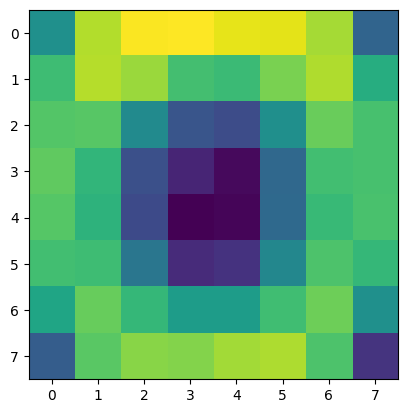

pixel0000    162.800000
pixel0001    175.513043
pixel0002    179.269565
pixel0003    179.408696
pixel0004    178.234783
                ...    
pixel0059    173.260870
pixel0060    174.791304
pixel0061    175.269565
pixel0062    170.156522
pixel0063    151.078261
Length: 64, dtype: float64


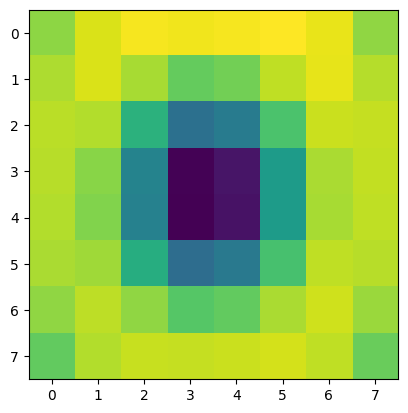

pixel0000    160.940940
pixel0001    168.746160
pixel0002    171.448173
pixel0003    171.073676
pixel0004    171.652796
                ...    
pixel0059    166.428486
pixel0060    167.078151
pixel0061    168.098732
pixel0062    166.084713
pixel0063    156.979120
Length: 64, dtype: float64


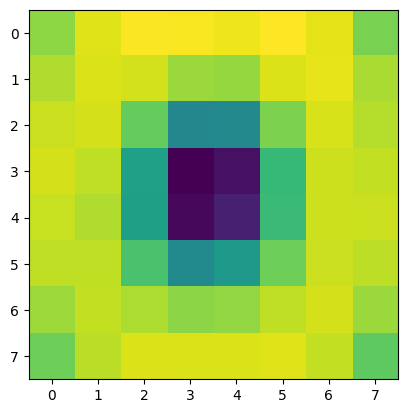

pixel0000    167.084507
pixel0001    175.161972
pixel0002    178.007042
pixel0003    177.802817
pixel0004    176.852113
                ...    
pixel0059    174.591549
pixel0060    174.591549
pixel0061    175.021127
pixel0062    172.323944
pixel0063    161.795775
Length: 64, dtype: float64


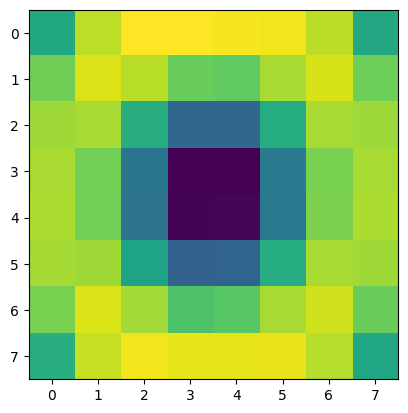

pixel0000    142.510332
pixel0001    163.004492
pixel0002    170.076370
pixel0003    169.930818
pixel0004    169.047619
                ...    
pixel0059    167.604672
pixel0060    167.491465
pixel0061    167.876909
pixel0062    162.164420
pixel0063    141.592992
Length: 64, dtype: float64


In [83]:
mean = []

for i in range(len(img_index_group)):
    mean.append(np.mean(data.iloc[img_index_group[i]], axis=0))
    
    disp_img(mean[i])
    print(mean[i])


### Substracting Mean for each diagnostic cathegory from the data of that cathegory

Corresponding E.3

In [84]:
data_sub_mean = pd.DataFrame()
for i in range(len(img_index_group)):
    data_sub_mean = pd.concat((data_sub_mean, data.loc[img_index_group[i]]-mean[i]))

data_sub_mean.sort_index(axis=0, inplace=True)
#data_sub_mean = data_sub_mean.transpose()

#IMPORTANT
#In the lecture, data is in the form (#pixels X #images)
#For us its in the form (#images X #pixels), thats why sometimes there is a transpose when there is none in the VL
#See comments (transpose is because of different data shape) in next code blocks
#Isnt done globally because it messes up the indexing in the data frame which we need to fiter the images belonging to a group
#This is why nearly next to all data_sub_mean.loc[img_index_gour[i]] there will be an additional .transpose() which does not come up in tne formulas from lecture

print(data_sub_mean)

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0      30.482257  23.567789  26.129208  17.171975  14.191993  17.055505   
1     -43.517743  -9.432211   5.129208  27.171975  17.191993  -1.944495   
2      23.482257   5.567789  14.129208   6.171975 -13.808007  -0.944495   
3     -32.517743   0.567789   2.129208   0.171975  -2.808007  -4.944495   
4      31.482257  43.567789  45.129208  28.171975  42.191993  84.055505   
...          ...        ...        ...        ...        ...        ...   
10010  38.149847  22.587156  14.516820  19.896024   4.605505  16.556575   
10011 -61.850153 -30.412844 -11.483180   4.896024  10.605505   5.556575   
10012  10.149847  21.587156  34.516820  48.896024  44.605505  33.556575   
10013 -16.850153 -17.412844 -22.483180 -17.103976  -4.394495   2.556575   
10014   9.489668 -11.004492 -20.076370 -21.930818 -13.047619  -9.582210   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0054  pixel0055  \
0       8.262056  2

### Calculating the Eigenvalues and Eigenvectores for each cathegory

Corresponding E.4

In [85]:
eig_vec = []
eig_val = []

#print(data_sub_mean.loc[img_index_group[0]])

for i in range(len(img_index_group)):
    matrix = data_sub_mean.loc[img_index_group[i]].transpose() #Last transpose is because of different data shape
    val, vec = np.linalg.eig(matrix.transpose().dot(matrix))
    eig_val.append(val)
    eig_vec.append(vec)

print(eig_val)
print(eig_vec)


[array([ 5.28173547e+06+0.00000000e+00j,  1.81978865e+06+0.00000000e+00j,
        1.25155009e+06+0.00000000e+00j,  6.23040464e+05+0.00000000e+00j,
        5.19117194e+05+0.00000000e+00j,  3.43500651e+05+0.00000000e+00j,
        3.38471120e+05+0.00000000e+00j,  2.98510084e+05+0.00000000e+00j,
        2.44331673e+05+0.00000000e+00j,  2.07326953e+05+0.00000000e+00j,
        1.44893795e+05+0.00000000e+00j,  1.25220082e+05+0.00000000e+00j,
        1.23916753e+05+0.00000000e+00j,  1.07988520e+05+0.00000000e+00j,
        1.01566022e+05+0.00000000e+00j,  9.74606107e+04+0.00000000e+00j,
        8.66191818e+04+0.00000000e+00j,  7.37535662e+04+0.00000000e+00j,
        6.72542816e+04+0.00000000e+00j,  6.05588365e+04+0.00000000e+00j,
        5.58537632e+04+0.00000000e+00j,  5.23433961e+04+0.00000000e+00j,
        5.09111903e+04+0.00000000e+00j,  4.93435161e+04+0.00000000e+00j,
        4.51912382e+04+0.00000000e+00j,  4.14551979e+04+0.00000000e+00j,
        3.86426671e+04+0.00000000e+00j,  3.2665169

### Sorting the Eigenvectors acording to the size of their corresponding Eigenvalues

Corresponding E.5

In [86]:
for i in range(len(img_index_group)):
    idx = eig_val[i].argsort()[::-1]
    eig_val[i] = eig_val[i][idx]
    eig_vec[i] = eig_vec[i][:, idx]

## Finishing Calculation and normalization of real EV 

Corresponding E.6 and E.7

TODO: Why is the calculation complex in the first place, should be real

Can be partially solved by casting comp as real but not for all caths

In [87]:
eig = []

for i in range(len(img_index_group)):
    eig_cath = data_sub_mean.loc[img_index_group[i]].transpose().dot(eig_vec[i]) #transpose is because of different data shape
    eig_cath = eig_cath.astype(np.float64) #applymap(np.absolute)
    eig.append(normalize(eig_cath, norm='l2', axis=0))

print(eig_cath)

c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


                  0           1           2           3           4     \
pixel0000  1213.298831  565.717390  571.689305 -275.035842   36.011439   
pixel0001   873.946512  275.000188  188.145968 -145.063219   93.185260   
pixel0002   706.616694   46.206460    7.657775 -106.543996  196.014681   
pixel0003   654.333029 -136.236632   -1.714334  -14.890232  337.899824   
pixel0004   678.844706 -159.016125  -20.108937  172.938561  289.489718   
...                ...         ...         ...         ...         ...   
pixel0059   627.783467 -143.423289  -97.923337   66.500770  186.597767   
pixel0060   643.181858 -127.569521  -72.024295  118.390829  132.582573   
pixel0061   696.173491   22.144350  -48.216999  114.191656   43.340046   
pixel0062   816.871813  232.505591   65.878202   94.757061  -14.844231   
pixel0063  1176.664047  608.314449  413.016932   -9.336506  -55.663015   

                 5           6           7           8           9     ...  \
pixel0000  332.376173  405.959107

c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\luisw\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


## Calculating of Principal Components C

Corresponding to F

TODO: Adaptation for Matrix calculation for Z

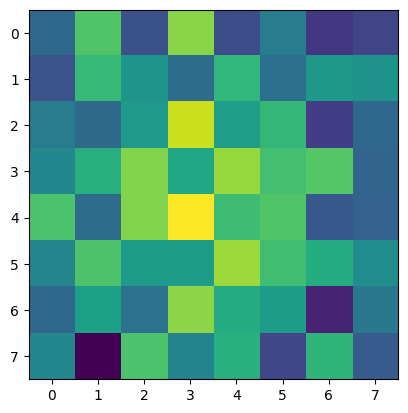

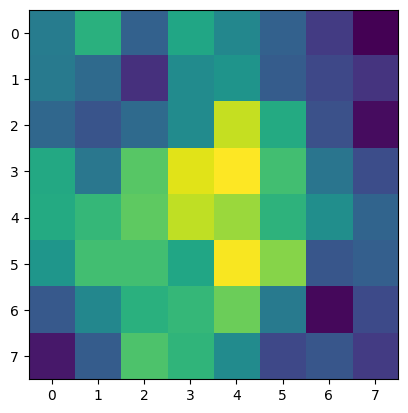

In [91]:
C = []
for i in range(len(img_index_group)):
    C.append(eig[i].transpose().dot(data_sub_mean.loc[img_index_group[i]].transpose()).transpose()) #Second to last transpose is because of different data shape

df_pca = df.copy()


img_idx = 0
cath_idx = 0
compression_factor = 0.5 

for i in range(len(img_index_group)):
    num_pca = round(len(C[i])*compression_factor)
    for j in range(len(img_index_group[i])):
        z = eig[i][:, :-num_pca].dot(C[i][j][:-num_pca]) + mean[i]
        df_pca.loc[img_index_group[i][j]].iloc[:-1] = z.astype(np.int64)

#z = eig[cath_idx][:, :-num_pca].dot(C[cath_idx][img_idx][:-num_pca]) + mean[cath_idx]
#df_pca.loc[img_index_group[cath_idx][img_idx]].iloc[:-1] = z.astype(np.int64)

disp_img(df_pca.loc[img_index_group[cath_idx][img_idx]])
cath_imgs = data.iloc[img_index_group[cath_idx]]
disp_img(cath_imgs.iloc[img_idx])


In [92]:
df_pca.to_csv(outpath, index=False)

NameError: name 'outpath' is not defined

## Trying PCS with only one cathegory to simplify

Mean
pixel0000    154.850153
pixel0001    169.412844
pixel0002    176.483180
pixel0003    178.103976
pixel0004    177.394495
                ...    
pixel0059    173.605505
pixel0060    173.418960
pixel0061    171.394495
pixel0062    164.333333
pixel0063    148.623853
Length: 64, dtype: float64


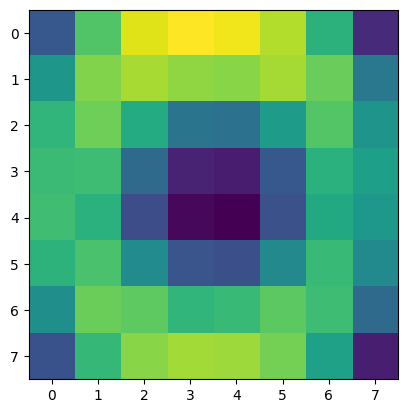

ValueError: Complex data not supported
                            0                     1                     2    \
pixel0000 -399.146187+0.000000j  178.130101+0.000000j -170.894405+0.000000j   
pixel0001 -353.063681+0.000000j   23.769626+0.000000j -137.515284+0.000000j   
pixel0002 -293.194745+0.000000j  -41.573588+0.000000j  -70.256749+0.000000j   
pixel0003 -270.628182+0.000000j  -63.260440+0.000000j  -11.533527+0.000000j   
pixel0004 -281.780609+0.000000j  -36.234138+0.000000j   40.255486+0.000000j   
...                         ...                   ...                   ...   
pixel0059 -283.026113+0.000000j  -38.292782+0.000000j   10.413389+0.000000j   
pixel0060 -284.252254+0.000000j  -12.877440+0.000000j   86.767163+0.000000j   
pixel0061 -296.427685+0.000000j   15.818741+0.000000j   97.085188+0.000000j   
pixel0062 -315.673948+0.000000j  146.308138+0.000000j  140.965622+0.000000j   
pixel0063 -391.370067+0.000000j  352.959005+0.000000j  167.493089+0.000000j   

                            3                     4                     5    \
pixel0000  142.136614+0.000000j -142.039069+0.000000j -138.299594+0.000000j   
pixel0001   52.882922+0.000000j -140.110495+0.000000j  -10.302484+0.000000j   
pixel0002  -38.200414+0.000000j -142.002105+0.000000j   64.625883+0.000000j   
pixel0003  -52.828024+0.000000j -135.422749+0.000000j   96.962182+0.000000j   
pixel0004  -50.588567+0.000000j -113.635468+0.000000j   88.032831+0.000000j   
...                         ...                   ...                   ...   
pixel0059   19.976001+0.000000j  110.594227+0.000000j  113.564301+0.000000j   
pixel0060   15.657390+0.000000j   95.386687+0.000000j  112.639723+0.000000j   
pixel0061  9.5310520+0.0000000j   98.354277+0.000000j  104.327705+0.000000j   
pixel0062   60.984194+0.000000j   73.583936+0.000000j   79.399986+0.000000j   
pixel0063  117.805135+0.000000j   21.641915+0.000000j  -34.161880+0.000000j   

                           6                     7                    8    \
pixel0000 -91.973966+0.000000j -144.881413+0.000000j  18.992981+0.000000j   
pixel0001 -79.572410+0.000000j   10.973341+0.000000j -46.526375+0.000000j   
pixel0002 -74.206412+0.000000j   17.042667+0.000000j -20.298069+0.000000j   
pixel0003 -54.617680+0.000000j -2.6232890+0.0000000j  30.683210+0.000000j   
pixel0004 -16.392433+0.000000j   29.793639+0.000000j  54.787867+0.000000j   
...                        ...                   ...                  ...   
pixel0059 -73.692161+0.000000j  -13.558475+0.000000j  10.898069+0.000000j   
pixel0060 -80.472761+0.000000j  -20.472778+0.000000j -31.843494+0.000000j   
pixel0061 -34.180152+0.000000j   39.558929+0.000000j -68.463804+0.000000j   
pixel0062  38.277282+0.000000j  5.7301450+0.0000000j -25.184115+0.000000j   
pixel0063  65.699021+0.000000j -153.880881+0.000000j  39.173570+0.000000j   

                           9    ...                         317  \
pixel0000 -21.185568+0.000000j  ... -6.572520e-14-7.926992e-14j   
pixel0001 -67.200245+0.000000j  ...  4.152234e-14-0.000000e+00j   
pixel0002 -67.593070+0.000000j  ...  5.218048e-15+1.350031e-13j   
pixel0003 -40.457104+0.000000j  ... -6.528111e-14+5.329071e-14j   
pixel0004 -26.217874+0.000000j  ...  7.394085e-14-6.217249e-14j   
...                        ...  ...                         ...   
pixel0059 -23.466251+0.000000j  ...  8.348877e-14+3.552714e-15j   
pixel0060   3.843441+0.000000j  ...  2.575717e-14-1.487699e-14j   
pixel0061  19.139490+0.000000j  ...  7.105427e-15+1.766642e-14j   
pixel0062  33.130380+0.000000j  ... -4.707346e-14-9.414691e-14j   
pixel0063  48.056531+0.000000j  ...  2.486900e-14+4.263256e-14j   

                                  318                         319  \
pixel0000 -6.572520e-14+7.926992e-14j -1.207923e-13+6.927792e-14j   
pixel0001  4.152234e-14-0.000000e+00j -3.419487e-14+2.131628e-14j   
pixel0002  5.218048e-15-1.350031e-13j  2.211564e-13-1.065814e-13j   
pixel0003 -6.528111e-14-5.329071e-14j  7.993606e-15-1.776357e-14j   
pixel0004  7.394085e-14+6.217249e-14j -1.506573e-13+3.552714e-15j   
...                               ...                         ...   
pixel0059  8.348877e-14-3.552714e-15j -4.585221e-14-4.440892e-14j   
pixel0060  2.575717e-14+1.487699e-14j -5.329071e-14-2.486900e-14j   
pixel0061  7.105427e-15-1.766642e-14j -7.460699e-14-4.352074e-14j   
pixel0062 -4.707346e-14+9.414691e-14j  8.881784e-16+6.750156e-14j   
pixel0063  2.486900e-14-4.263256e-14j -5.861978e-14-4.085621e-14j   

                                  320                         321  \
pixel0000 -1.207923e-13-6.927792e-14j -1.421085e-14+0.000000e+00j   
pixel0001 -3.419487e-14-2.131628e-14j -1.598721e-13+0.000000e+00j   
pixel0002  2.211564e-13+1.065814e-13j  1.083578e-13+0.000000e+00j   
pixel0003  7.993606e-15+1.776357e-14j  1.882938e-13+0.000000e+00j   
pixel0004 -1.506573e-13-3.552714e-15j -1.421085e-13+0.000000e+00j   
...                               ...                         ...   
pixel0059 -4.585221e-14+4.440892e-14j  9.325873e-14+0.000000e+00j   
pixel0060 -5.329071e-14+2.486900e-14j  3.019807e-14+0.000000e+00j   
pixel0061 -7.460699e-14+4.352074e-14j  5.839773e-14+0.000000e+00j   
pixel0062  8.881784e-16-6.750156e-14j -1.429967e-13+0.000000e+00j   
pixel0063 -5.861978e-14+4.085621e-14j  5.906386e-14+0.000000e+00j   

                                  322                         323  \
pixel0000  7.993606e-15-8.171241e-14j  7.993606e-15+8.171241e-14j   
pixel0001  1.527667e-13+5.329071e-15j  1.527667e-13-5.329071e-15j   
pixel0002 -1.278977e-13+1.332268e-13j -1.278977e-13-1.332268e-13j   
pixel0003  1.065814e-14-6.128431e-14j  1.065814e-14+6.128431e-14j   
pixel0004  8.082424e-14+7.460699e-14j  8.082424e-14-7.460699e-14j   
...                               ...                         ...   
pixel0059  6.394885e-14-1.865175e-14j  6.394885e-14+1.865175e-14j   
pixel0060 -8.215650e-15-1.598721e-14j -8.215650e-15+1.598721e-14j   
pixel0061  6.927792e-14+5.151435e-14j  6.927792e-14-5.151435e-14j   
pixel0062  2.664535e-14-7.904788e-14j  2.664535e-14+7.904788e-14j   
pixel0063  1.776357e-14+9.414691e-14j  1.776357e-14-9.414691e-14j   

                                  324                         325  \
pixel0000  2.131628e-14+0.000000e+00j  9.059420e-14+9.947598e-14j   
pixel0001 -1.847411e-13+0.000000e+00j -1.083578e-13-6.394885e-14j   
pixel0002  7.815970e-14+0.000000e+00j -6.394885e-14-4.618528e-14j   
pixel0003  1.278977e-13+0.000000e+00j  5.062617e-14-1.065814e-14j   
pixel0004 -9.592327e-14+0.000000e+00j  4.440892e-14+5.329071e-14j   
...                               ...                         ...   
pixel0059  5.417888e-14+0.000000e+00j -5.373479e-14-8.881784e-14j   
pixel0060  6.439294e-14+0.000000e+00j  1.088019e-13+1.065814e-13j   
pixel0061  6.039613e-14+0.000000e+00j -3.774758e-14+3.552714e-14j   
pixel0062 -1.240119e-13+0.000000e+00j  0.000000e+00-7.105427e-15j   
pixel0063  1.048051e-13+0.000000e+00j  1.070255e-13+7.105427e-15j   

                                  326  
pixel0000  9.059420e-14-9.947598e-14j  
pixel0001 -1.083578e-13+6.394885e-14j  
pixel0002 -6.394885e-14+4.618528e-14j  
pixel0003  5.062617e-14+1.065814e-14j  
pixel0004  4.440892e-14-5.329071e-14j  
...                               ...  
pixel0059 -5.373479e-14+8.881784e-14j  
pixel0060  1.088019e-13-1.065814e-13j  
pixel0061 -3.774758e-14-3.552714e-14j  
pixel0062  0.000000e+00+7.105427e-15j  
pixel0063  1.070255e-13-7.105427e-15j  

[64 rows x 327 columns]


In [90]:
data_1 = df.loc[img_index_group[0]]
data_1 = data_1.iloc[:, :-1]

mean_1 = np.mean(data_1, axis=0)
print("Mean")
print(mean_1)
disp_img(mean_1)


data_submean = data_1 - mean_1
data_submean = data_submean.transpose()

eval, evec = np.linalg.eig(data_submean.transpose().dot(data_submean))

idx1 = eval.argsort()[::-1]
eval = eval[idx1]
evec = evec[:, idx1]


U = data_submean.dot(evec)

U = normalize(U, norm='l2', axis=0)

C1 = U.transpose().dot(data_submean).transpose()

#print("First eigenvector")
#disp_img(U[:, 0])
#print("Second eigenvector")
#disp_img(U[:, 1])

img_index = 0
z = U.dot(C1[img_index]) + mean_1

print(U.shape)

print("Reconstructed Image")
disp_img(z)

print("Actual image")
disp_img(data_1.iloc[img_index])

